# Synthetic Experiments

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pylab as plt
import math

from utils.xedl import xEDLWrapper
from copy import deepcopy
from sklearn.neighbors import KernelDensity

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def plot_contour(net, X, y, width=4, res=.01):
    net.cpu()
    xx, yy = np.mgrid[-width:width:res, -width:width:res]
    zz = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title('Aleatoric Uncertainty -- $u_a$')
    with torch.no_grad():
        aleatoric_unc = net.predict_aleatoric(zz)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=4, s=10)
    c = plt.contourf(xx, yy, aleatoric_unc.view(xx.shape), levels=np.linspace(0, 1, 6), zorder=3, alpha=.7)
    plt.colorbar(c)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Feature $x_1$')
    plt.ylabel('Feature $x_2$')

    plt.subplot(122)
    plt.title('Epistemic Uncertainty -- $u_e$')
    with torch.no_grad():
        epistemic_unc = net.predict_epistemic(zz)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=4, s=10)
    c = plt.contourf(xx, yy, epistemic_unc.view(xx.shape), levels=np.linspace(0, 1, 6), zorder=3, alpha=.7)
    plt.colorbar(c)
    plt.xlabel('Feature $x_1$')
    plt.ylabel('Feature $x_2$')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

## Aleatoric Uncertainty

In [3]:
resolution = 100
n_epochs = 500

n_samples_train = 200
n_samples_test = 200
random_state = 1
var = 1

bw = .1
net_init = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 2))
net_init.n_classes = 2

results_aleatoric = []
means = np.linspace(0, 2.5, resolution)

lmbds = [0.1, 0.3, .5, .7, .9]
for lmb in lmbds:
    mean_distance = []
    aleatoric_uncertainties = []
    for mean in means:
        torch.manual_seed(random_state)
        X = torch.cat((torch.Tensor(n_samples_train//2, 2).normal_(-mean, var), torch.Tensor(n_samples_train//2, 2).normal_(mean, var)))
        y = torch.cat((torch.zeros(n_samples_train//2), torch.ones(n_samples_train//2))).long()
        X = (X - X.mean(0)) / X.std(0)
        X_train, y_train = X, y

        X_test = torch.cat((torch.Tensor(n_samples_test//2, 2).normal_(-mean, var), torch.Tensor(n_samples_test//2, 2).normal_(mean, var)))
        y_test = torch.cat((torch.zeros(n_samples_test//2), torch.ones(n_samples_test//2))).long()
        X_test = (X_test - X_test.mean(0)) / X_test.std(0)

        kde = KernelDensity(bandwidth=bw).fit(X_train)
        def gen_ood(X_batch, y_batch=None, boundary=1e-5, *args, **kwargs):
            device = X_batch.device
            n_samples = len(X_batch)
            ood_samples = []
            while len(ood_samples) < n_samples:
                outer = np.random.multivariate_normal(np.zeros(2), np.eye(2)*3, size=1000)
                ood_samples.extend(outer[kde.score_samples(outer) < np.log(boundary)])

            return torch.from_numpy(np.stack(ood_samples)).float()[:n_samples].to(device)

        train_ds = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)

        net = xEDLWrapper(net=deepcopy(net_init), lmb=lmb, ood_generator=gen_ood)
        net.fit(
            train_loader,
            val_loader_in=train_loader,
            val_loader_out=train_loader,
            n_epochs=n_epochs,
            weight_decay=1e-3,
            verbose=0,
            device=device,
        )
        net.cpu()
        # plot_contour(net, X_test, y_test)
        mean_distance.append(math.sqrt((mean - -mean)**2))
        aleatoric_uncertainties.append(net.predict_aleatoric(X_test).mean())
    results_aleatoric.append((mean_distance, aleatoric_uncertainties))

Training on cuda.


[Ep 499] Loss (In/Out) = 0.695/0.028 | Acc=0.520/0.520 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.696/0.043 | Acc=0.510/0.510 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.696/0.027 | Acc=0.520/0.520 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.694/0.031 | Acc=0.525/0.525 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.036 | Acc=0.545/0.550 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.689/0.042 | Acc=0.565/0.565 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.685/0.038 | Acc=0.580/0.580 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.680/0.049 | Acc=0.615/0.615 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.673/0.056 | Acc=0.620/0.620 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.664/0.060 | Acc=0.630/0.630 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.655/0.073 | Acc=0.640/0.640 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.644/0.080 | Acc=0.665/0.665 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.633/0.081 | Acc=0.670/0.670 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.620/0.085 | Acc=0.675/0.675 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.608/0.090 | Acc=0.685/0.685 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.594/0.086 | Acc=0.685/0.685 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.583/0.095 | Acc=0.710/0.710 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.569/0.080 | Acc=0.715/0.715 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.554/0.111 | Acc=0.725/0.725 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.540/0.083 | Acc=0.725/0.725 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.525/0.094 | Acc=0.735/0.735 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.512/0.113 | Acc=0.750/0.750 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.497/0.095 | Acc=0.765/0.765 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.480/0.120 | Acc=0.770/0.770 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.466/0.115 | Acc=0.775/0.775 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.451/0.102 | Acc=0.790/0.790 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.434/0.123 | Acc=0.795/0.800 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.422/0.062 | Acc=0.800/0.800 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.406/0.090 | Acc=0.820/0.820 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.393/0.082 | Acc=0.830/0.830 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.380/0.103 | Acc=0.835/0.835 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.365/0.059 | Acc=0.835/0.835 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.350/0.074 | Acc=0.845/0.845 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.335/0.098 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.322/0.106 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.307/0.072 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.290/0.088 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.277/0.110 | Acc=0.870/0.870 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.260/0.107 | Acc=0.870/0.870 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.248/0.081 | Acc=0.875/0.875 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.231/0.094 | Acc=0.880/0.880 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.219/0.092 | Acc=0.900/0.900 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.205/0.080 | Acc=0.915/0.915 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.192/0.128 | Acc=0.930/0.930 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.178/0.096 | Acc=0.935/0.935 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.166/0.106 | Acc=0.940/0.940 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.154/0.121 | Acc=0.950/0.950 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.145/0.086 | Acc=0.955/0.955 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.134/0.123 | Acc=0.955/0.955 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.122/0.128 | Acc=0.965/0.965 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.113/0.102 | Acc=0.965/0.965 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.103/0.133 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.093/0.114 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.085/0.098 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.077/0.097 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.071/0.094 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.066/0.088 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.058/0.082 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.051/0.089 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.048/0.078 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.043/0.082 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.037/0.068 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.033/0.111 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.031/0.062 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.027/0.071 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.024/0.101 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.021/0.089 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.083 | Acc=1.000/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.021/0.050 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.019/0.071 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.016/0.099 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.015/0.072 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.014/0.038 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.014/0.088 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.013/0.100 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.014/0.049 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.014/0.061 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.074 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.126 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.013/0.061 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.080 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.084 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.071 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.081 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.076 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.068 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.084 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.080 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.084 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.010/0.066 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.086 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.096 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.009/0.099 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.012/0.048 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.072 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.010/0.121 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.065 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.077 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.010/0.096 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.011/0.070 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.701/0.007 | Acc=0.505/0.505 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.701/0.007 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.700/0.007 | Acc=0.510/0.510 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.698/0.006 | Acc=0.510/0.515 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.695/0.009 | Acc=0.525/0.525 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.007 | Acc=0.545/0.545 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.689/0.007 | Acc=0.560/0.560 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.686/0.008 | Acc=0.580/0.580 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.682/0.012 | Acc=0.615/0.615 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.676/0.011 | Acc=0.615/0.615 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.671/0.013 | Acc=0.635/0.635 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.664/0.013 | Acc=0.645/0.650 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.654/0.018 | Acc=0.670/0.670 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.644/0.017 | Acc=0.675/0.675 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.628/0.018 | Acc=0.685/0.685 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.613/0.022 | Acc=0.690/0.690 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.600/0.025 | Acc=0.715/0.715 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.584/0.021 | Acc=0.715/0.715 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.569/0.016 | Acc=0.720/0.720 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.555/0.034 | Acc=0.725/0.725 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.540/0.034 | Acc=0.735/0.735 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.526/0.031 | Acc=0.745/0.745 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.514/0.031 | Acc=0.760/0.760 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.500/0.021 | Acc=0.765/0.765 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.481/0.036 | Acc=0.770/0.770 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.471/0.030 | Acc=0.790/0.790 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.449/0.041 | Acc=0.795/0.795 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.437/0.014 | Acc=0.805/0.805 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.421/0.027 | Acc=0.815/0.815 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.408/0.029 | Acc=0.825/0.825 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.393/0.021 | Acc=0.830/0.830 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.378/0.031 | Acc=0.840/0.840 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.365/0.039 | Acc=0.835/0.835 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.348/0.022 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.331/0.022 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.319/0.030 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.303/0.028 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.288/0.036 | Acc=0.870/0.870 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.274/0.041 | Acc=0.875/0.875 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.257/0.048 | Acc=0.875/0.875 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.245/0.031 | Acc=0.895/0.895 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.229/0.026 | Acc=0.905/0.905 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.214/0.054 | Acc=0.910/0.910 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.206/0.028 | Acc=0.920/0.920 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.194/0.026 | Acc=0.925/0.925 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.179/0.021 | Acc=0.940/0.940 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.164/0.040 | Acc=0.950/0.950 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.155/0.031 | Acc=0.955/0.955 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.144/0.041 | Acc=0.955/0.960 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.137/0.027 | Acc=0.965/0.965 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.123/0.023 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.117/0.013 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.106/0.019 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.099/0.015 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.090/0.019 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.084/0.025 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.075/0.043 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.070/0.028 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.064/0.023 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.061/0.024 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.055/0.019 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.052/0.022 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.046/0.017 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.042/0.034 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.036/0.023 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.038/0.011 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.034/0.028 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.032/0.017 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.031/0.029 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.028/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.027/0.025 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.023/0.041 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.028/0.014 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.025/0.020 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.024/0.022 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.023/0.013 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.021/0.033 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.021/0.028 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.018/0.028 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.035 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.022/0.021 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.036 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.017/0.027 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.019/0.037 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.021/0.011 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.026 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.016 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.018/0.021 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.018/0.032 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.018/0.022 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.018/0.014 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.017/0.042 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.016/0.046 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.016/0.040 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.020/0.025 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.016/0.026 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.016/0.024 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.017/0.021 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.015/0.035 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.703/0.003 | Acc=0.495/0.495 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.701/0.002 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.700/0.002 | Acc=0.505/0.505 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.697/0.003 | Acc=0.510/0.510 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.696/0.003 | Acc=0.520/0.520 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.002 | Acc=0.530/0.530 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.690/0.002 | Acc=0.545/0.545 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.687/0.004 | Acc=0.580/0.580 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.684/0.005 | Acc=0.585/0.585 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.681/0.004 | Acc=0.620/0.620 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.677/0.005 | Acc=0.625/0.625 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.673/0.008 | Acc=0.630/0.630 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.668/0.006 | Acc=0.660/0.660 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.660/0.009 | Acc=0.670/0.670 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.652/0.010 | Acc=0.675/0.675 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.641/0.007 | Acc=0.690/0.690 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.625/0.013 | Acc=0.715/0.715 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.604/0.011 | Acc=0.725/0.725 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.587/0.007 | Acc=0.730/0.730 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.571/0.014 | Acc=0.735/0.735 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.557/0.007 | Acc=0.740/0.740 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.542/0.015 | Acc=0.745/0.745 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.529/0.013 | Acc=0.755/0.750 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.516/0.011 | Acc=0.750/0.750 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.501/0.015 | Acc=0.780/0.780 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.485/0.018 | Acc=0.790/0.790 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.471/0.020 | Acc=0.800/0.800 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.456/0.017 | Acc=0.800/0.800 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.442/0.012 | Acc=0.820/0.820 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.427/0.016 | Acc=0.815/0.815 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.412/0.006 | Acc=0.815/0.815 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.394/0.020 | Acc=0.835/0.835 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.381/0.013 | Acc=0.830/0.830 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.365/0.026 | Acc=0.855/0.850 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.348/0.022 | Acc=0.850/0.850 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.335/0.019 | Acc=0.850/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.322/0.028 | Acc=0.855/0.860 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.306/0.017 | Acc=0.865/0.865 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.290/0.008 | Acc=0.880/0.875 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.275/0.006 | Acc=0.880/0.880 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.258/0.017 | Acc=0.905/0.905 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.244/0.020 | Acc=0.910/0.910 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.232/0.022 | Acc=0.915/0.915 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.217/0.007 | Acc=0.920/0.920 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.203/0.014 | Acc=0.930/0.930 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.191/0.028 | Acc=0.945/0.945 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.182/0.013 | Acc=0.950/0.950 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.163/0.021 | Acc=0.950/0.950 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.154/0.012 | Acc=0.960/0.960 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.145/0.017 | Acc=0.960/0.960 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.132/0.006 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.127/0.010 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.116/0.011 | Acc=0.975/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.110/0.007 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.101/0.010 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.088/0.037 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.084/0.012 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.080/0.010 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.077/0.012 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.069/0.008 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.063/0.010 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.057/0.017 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.054/0.011 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.049/0.010 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.051/0.008 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.045/0.005 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.041/0.010 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.040/0.010 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.037/0.020 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.036/0.011 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.034/0.016 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.034/0.018 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.034/0.012 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.034/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.029/0.018 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.031/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.032/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.031/0.009 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.032/0.011 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.030/0.012 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.030/0.012 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.031/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.028/0.019 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.027/0.014 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.027/0.009 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.026/0.013 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.029/0.012 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.028/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.028/0.011 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.027/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.030/0.009 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.028/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.031/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.025/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.025/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.027/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.023/0.016 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.023/0.016 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.021/0.016 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.023/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.695/0.002 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.695/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.695/0.002 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.694/0.002 | Acc=0.505/0.505 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.694/0.002 | Acc=0.510/0.510 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.002 | Acc=0.520/0.520 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.691/0.002 | Acc=0.540/0.540 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.689/0.002 | Acc=0.545/0.545 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.686/0.002 | Acc=0.560/0.560 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.684/0.002 | Acc=0.575/0.575 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.682/0.002 | Acc=0.580/0.580 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.679/0.002 | Acc=0.595/0.595 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.675/0.003 | Acc=0.630/0.630 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.670/0.004 | Acc=0.635/0.635 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.665/0.005 | Acc=0.640/0.640 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.660/0.005 | Acc=0.670/0.670 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.654/0.003 | Acc=0.675/0.675 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.647/0.005 | Acc=0.695/0.695 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.639/0.004 | Acc=0.700/0.700 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.629/0.005 | Acc=0.725/0.725 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.615/0.006 | Acc=0.740/0.740 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.598/0.004 | Acc=0.745/0.745 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.579/0.006 | Acc=0.755/0.755 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.554/0.006 | Acc=0.760/0.760 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.539/0.007 | Acc=0.780/0.780 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.517/0.004 | Acc=0.790/0.790 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.495/0.010 | Acc=0.790/0.795 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.483/0.012 | Acc=0.810/0.810 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.463/0.011 | Acc=0.815/0.815 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.450/0.007 | Acc=0.815/0.815 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.434/0.008 | Acc=0.825/0.825 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.422/0.006 | Acc=0.820/0.820 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.405/0.007 | Acc=0.835/0.835 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.391/0.012 | Acc=0.845/0.845 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.373/0.008 | Acc=0.845/0.845 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.359/0.023 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.348/0.005 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.329/0.006 | Acc=0.855/0.855 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.316/0.007 | Acc=0.865/0.870 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.298/0.007 | Acc=0.885/0.885 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.282/0.006 | Acc=0.895/0.895 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.265/0.009 | Acc=0.905/0.905 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.252/0.008 | Acc=0.910/0.910 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.231/0.009 | Acc=0.920/0.920 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.223/0.020 | Acc=0.930/0.930 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.210/0.008 | Acc=0.935/0.935 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.205/0.006 | Acc=0.950/0.950 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.182/0.009 | Acc=0.955/0.955 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.174/0.008 | Acc=0.955/0.955 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.165/0.004 | Acc=0.960/0.960 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.152/0.003 | Acc=0.965/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.142/0.006 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.133/0.004 | Acc=0.975/0.975 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.121/0.013 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.120/0.005 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.108/0.005 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.094/0.019 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.091/0.004 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.090/0.007 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.090/0.003 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.081/0.006 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.073/0.007 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.070/0.007 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.072/0.003 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.060/0.003 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.061/0.006 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.059/0.006 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.059/0.003 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.057/0.005 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.052/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.047/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.046/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.052/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.045/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.042/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.041/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.043/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.048/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.042/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.043/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.045/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.042/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.044/0.009 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.041/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.038/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.039/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.040/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.042/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.037/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.042/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.046/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.041/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.041/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.038/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.035/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.035/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.040/0.008 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.041/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.036/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.039/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.693/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.692/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.691/0.001 | Acc=0.500/0.500 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.691/0.001 | Acc=0.525/0.525 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.690/0.001 | Acc=0.570/0.565 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.690/0.001 | Acc=0.595/0.595 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.689/0.001 | Acc=0.615/0.615 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.688/0.001 | Acc=0.645/0.645 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.687/0.001 | Acc=0.665/0.665 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.686/0.001 | Acc=0.680/0.680 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.684/0.001 | Acc=0.690/0.690 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.682/0.001 | Acc=0.695/0.695 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.681/0.001 | Acc=0.720/0.720 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.677/0.001 | Acc=0.730/0.730 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.673/0.001 | Acc=0.750/0.745 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.668/0.001 | Acc=0.755/0.755 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.660/0.002 | Acc=0.750/0.750 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.648/0.002 | Acc=0.770/0.770 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.640/0.001 | Acc=0.770/0.770 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.611/0.002 | Acc=0.785/0.785 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.587/0.003 | Acc=0.815/0.815 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.588/0.002 | Acc=0.825/0.825 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.564/0.003 | Acc=0.825/0.825 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.551/0.002 | Acc=0.835/0.830 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.541/0.003 | Acc=0.840/0.840 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.532/0.002 | Acc=0.850/0.845 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.519/0.002 | Acc=0.845/0.845 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.508/0.003 | Acc=0.850/0.850 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.499/0.002 | Acc=0.860/0.860 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.495/0.002 | Acc=0.850/0.850 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.483/0.001 | Acc=0.890/0.890 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.472/0.002 | Acc=0.890/0.890 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.464/0.002 | Acc=0.895/0.895 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.454/0.002 | Acc=0.900/0.900 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.445/0.004 | Acc=0.900/0.900 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.438/0.002 | Acc=0.905/0.910 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.434/0.002 | Acc=0.915/0.915 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.421/0.003 | Acc=0.925/0.920 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.417/0.003 | Acc=0.925/0.925 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.396/0.003 | Acc=0.935/0.935 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.395/0.003 | Acc=0.945/0.945 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.374/0.004 | Acc=0.945/0.945 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.377/0.003 | Acc=0.970/0.970 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.357/0.003 | Acc=0.975/0.975 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.318/0.003 | Acc=0.975/0.975 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.341/0.004 | Acc=0.975/0.975 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.317/0.003 | Acc=0.975/0.975 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.311/0.002 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.302/0.002 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.289/0.002 | Acc=0.980/0.980 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.272/0.003 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.283/0.004 | Acc=0.985/0.985 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.261/0.004 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.256/0.004 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.243/0.004 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.242/0.003 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.212/0.006 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.222/0.004 | Acc=0.990/0.990 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.202/0.004 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.215/0.002 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.198/0.006 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.183/0.004 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.195/0.003 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.187/0.003 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.176/0.003 | Acc=0.995/0.995 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.176/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.188/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.184/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.179/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.193/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.184/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.185/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.190/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.197/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.192/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.176/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.190/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.217/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.189/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.193/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.213/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.207/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.209/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.220/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.212/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.198/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 499] Loss (In/Out) = 0.223/0.005 | Acc=1.000/1.000 | AUROC=0.500



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


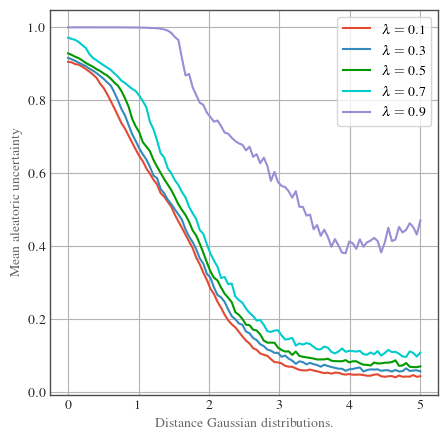

In [4]:
plt.figure(figsize=(5, 5))
for lmb, (mean_distance, aleatoric_uncertainties) in zip(lmbds, results_aleatoric):
    plt.plot(mean_distance, aleatoric_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.xlabel('Distance Gaussian distributions.')
    plt.ylabel('Mean aleatoric uncertainty')
    plt.legend()
plt.show()

## Epistemic Uncertainty

In [7]:
n_epochs = 1000
mean = 2
random_state = 1
mean = 2
var = 1

n_samples_train = 500
n_samples_test = 500

n_draw = 2
steps = 20
n_samples_all = np.arange(2, 30, 2)

torch.manual_seed(random_state)
net_init = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 2))

torch.manual_seed(random_state)
X_test = torch.cat((torch.Tensor(n_samples_test//2, 2).normal_(-mean, var), torch.Tensor(n_samples_test//2, 2).normal_(mean, var)))
y_test = torch.cat((torch.zeros(n_samples_test//2), torch.ones(n_samples_test//2))).long()
X_test = (X_test - X_test.mean(0)) / X_test.std(0)

torch.manual_seed(random_state)
X = torch.cat((torch.Tensor(n_samples_train//2, 2).normal_(-mean, var), torch.Tensor(n_samples_train//2, 2).normal_(mean, var)))
y = torch.cat((torch.zeros(n_samples_train//2), torch.ones(n_samples_train//2))).long()
X = (X - X.mean(0)) / X.std(0)

results_epistemic = []

lmbds = [0.1, 0.3, .5, .7, .9]
for lmb in lmbds:
    epistemic_uncertainties = []
    n_samples_cur = []
    idx = list(range(len(X)))
    train_idx = []
    np.random.seed(0)

    for _ in range(steps):
        idx_add = np.c_[np.random.choice(idx[:n_samples_train//2], size=n_draw//2), np.random.choice(idx[n_samples_train//2:], size=n_draw//2)].flatten()
        for i in idx_add:
            idx.remove(i)
        train_idx.extend(idx_add)

        X_train, y_train = X[train_idx], y[train_idx]
        train_ds = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)

        kde = KernelDensity(bandwidth=.1).fit(X_train)
        def gen_ood(X_batch, y_batch=None, boundary=1e-5, *args, **kwargs):
            device = X_batch.device
            n_samples = len(X_batch)
            ood_samples = []
            while len(ood_samples) < n_samples:
                outer = np.random.multivariate_normal(np.zeros(2), np.eye(2)*5, size=1000)
                ood_samples.extend(outer[kde.score_samples(outer) < np.log(boundary)])

            return torch.from_numpy(np.stack(ood_samples)).float()[:n_samples].to(device)
        
        net_init.n_classes = 2
        net = xEDLWrapper(net=deepcopy(net_init), lmb=lmb, ood_generator=gen_ood)
        net.fit(
            train_loader,
            val_loader_in=train_loader,
            val_loader_out=train_loader,
            n_epochs=n_epochs,
            weight_decay=1e-3,
            verbose=0,
            device=device,
        )
        net.cpu()

        # Create big and fixed size of test samples for representative evalaution of epistemicj
        # plot_contour(net, X_test, y_test, width=X_test.max().item(), res=.1)
        epistemic_uncertainties.append(net.predict_epistemic(X_test).mean())
        n_samples_cur.append(len(X_train))
    results_epistemic.append((n_samples_cur, epistemic_uncertainties))

Training on cuda.


[Ep 999] Loss (In/Out) = 0.010/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.010/0.020 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.012/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.008/0.215 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.009/0.090 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.009/0.132 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.008/0.058 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.006/0.043 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.008/0.145 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.009/0.038 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.009/0.024 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.009/0.127 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.008/0.224 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.010/0.043 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.008/0.094 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.007/0.164 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.007/0.161 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.006/0.023 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.009/0.074 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.007/0.095 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.022/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.015/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.020/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.013/0.050 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.017/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.013/0.038 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.013/0.010 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.010/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.014/0.054 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.016/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.017/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.015/0.066 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.014/0.076 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.018/0.012 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.014/0.027 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.011/0.074 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.011/0.090 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.010/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.013/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.011/0.025 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.035/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.023/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.030/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.020/0.027 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.027/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.019/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.021/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.015/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.021/0.039 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.023/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.023/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.020/0.045 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.021/0.041 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.027/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.022/0.012 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.016/0.043 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.017/0.054 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.014/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.019/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.015/0.013 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.054/-0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.042/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.053/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.035/0.015 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.051/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.033/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.040/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.026/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.035/0.027 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.042/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.039/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.032/0.036 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.034/0.027 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.045/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.036/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.027/0.027 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.030/0.033 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.024/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.033/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.026/0.009 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.610/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.569/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.618/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.611/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.558/0.001 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.596/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.524/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.485/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.441/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.463/0.003 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.404/0.004 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.360/0.016 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.329/0.013 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.301/0.005 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.223/0.007 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.340/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.294/0.009 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.177/0.002 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.292/0.006 | Acc=1.000/1.000 | AUROC=0.500

Training on cuda.


[Ep 999] Loss (In/Out) = 0.159/0.007 | Acc=1.000/1.000 | AUROC=0.500



In [12]:
plt.figure(figsize=(5, 5))
for lmb, (samples, epistemic_uncertainties) in zip(lmbds, results_epistemic):
    plt.plot(samples, epistemic_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Epistemic Uncertainty')
    plt.legend()
plt.show()

<Figure size 480x480 with 0 Axes>

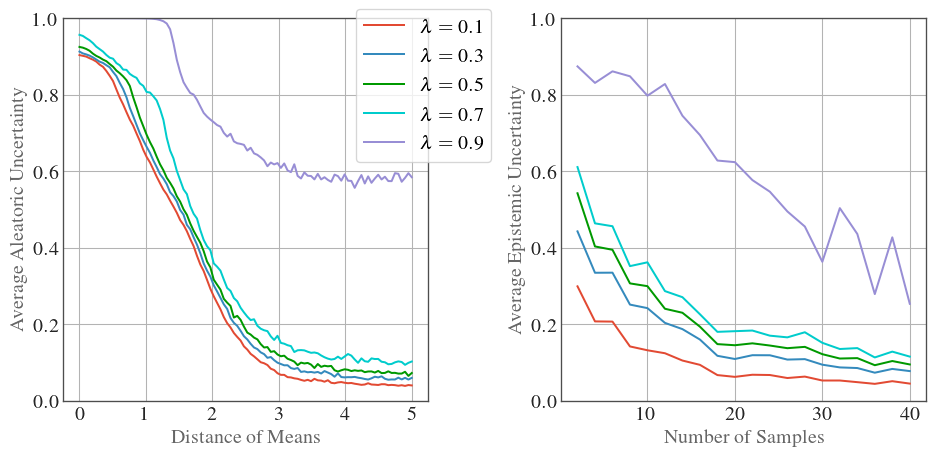

In [54]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)

for lmb, (mean_distance, aleatoric_uncertainties) in zip(lmbds, results_aleatoric):
    plt.plot(mean_distance, aleatoric_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.ylim([0, 1])
    plt.xlabel('Distance of Means')
    plt.ylabel('Average Aleatoric Uncertainty')
          
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.subplot(122, sharey=ax)
          
for lmb, (samples, epistemic_uncertainties) in zip(lmbds, results_epistemic):
    plt.plot(samples, epistemic_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Epistemic Uncertainty')

plt.tight_layout()
plt.savefig('./plots/synthetic.pdf')
plt.show()